In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import sklearn.model_selection

In [19]:
dataset = pd.read_csv('news.csv', sep=',') # or sampled_news_final.csv
dataset = dataset.drop(['Unnamed: 0', 'Title', 'SentimentTitle'], axis=1)
dataset.columns = ['text', 'sentiment']
dataset.shape

(93239, 2)

In [20]:
dataset.head()

,text,sentiment
0,Obama Lays Wreath at Arlington National Cemete...,1
1,"Tim Haywood, investment director business-unit...",1
2,"Nouriel Roubini, NYU professor and chairman at...",1
3,Finland's economy expanded marginally in the t...,1
4,Tourism and public spending continued to boost...,1


In [21]:
dataset['sentiment'].value_counts()

1    92990
0      158
2       91
Name: sentiment, dtype: int64

In [5]:
X, y = dataset['text'].astype(str).tolist(), dataset['sentiment'].tolist()
NUM_CLASSES = 3

In [6]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()

tokenizer.fit_on_texts(X)
X_encoded = tokenizer.texts_to_sequences(X)
vocab_size = len(tokenizer.word_index) + 1

MAX_LEN = max([len(n) for n in X_encoded])
print(MAX_LEN)
X_encoded = tf.keras.preprocessing.sequence.pad_sequences(X_encoded, maxlen=MAX_LEN)

# One Hot Encoding Target
y_encoded = np.eye(NUM_CLASSES, dtype='int')[y].astype(float)

61


In [7]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_encoded, y_encoded, test_size=0.1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((250921, 61), (27881, 61), (250921, 3), (27881, 3))

# Model

In [8]:
import numpy as np

class Embeddings():
    def __init__(self, path, vector_dimension):
        self.path = path 
        self.vector_dimension = vector_dimension
    
    @staticmethod
    def get_coefs(word, *arr): 
        return word, np.asarray(arr)

    def get_embedding_index(self):
        embeddings_index = dict(self.get_coefs(*o.split(" ")) for o in open(self.path, 'r', errors='ignore', encoding='utf-8'))
        return embeddings_index

    def create_embedding_matrix(self, tokenizer, max_features):
        model_embed = self.get_embedding_index()
        embedding_matrix = np.zeros((max_features + 1, self.vector_dimension))
        for word, index in tokenizer.word_index.items():
            if index > max_features:
                break
            else:
                try:
                    embedding_matrix[index] = model_embed[word]
                except:
                    continue
        return embedding_matrix

In [9]:
#Word embedding

#Import GloVe embeddings or other pretrained embeddings
embedding = Embeddings(
    path = 'glove.6B.200d.txt',
    vector_dimension = 200,
)

embedding_matrix = embedding.create_embedding_matrix(tokenizer, vocab_size)
embedding_dim = 200

In [10]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embed_dim)
        self.key_dense = tf.keras.layers.Dense(embed_dim)
        self.value_dense = tf.keras.layers.Dense(embed_dim)
        self.combine_heads = tf.keras.layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [11]:
def categorical_focal_loss(classes_num, gamma=4., alpha=.25, e=0.1):
    def focal_loss_fixed(target_tensor, prediction_tensor):
        import tensorflow as tf
        from tensorflow.python.ops import array_ops
        from keras import backend as K
        
        #1# get focal loss with no balanced weight which presented in paper function (4)
        zeros = array_ops.zeros_like(prediction_tensor, dtype=prediction_tensor.dtype)
        one_minus_p = array_ops.where(tf.greater(target_tensor,zeros), target_tensor - prediction_tensor, zeros)
        FT = -1 * (one_minus_p ** gamma) * tf.math.log(tf.clip_by_value(prediction_tensor, 1e-8, 1.0))

        #2# get balanced weight alpha
        classes_weight = array_ops.zeros_like(prediction_tensor, dtype=prediction_tensor.dtype)

        total_num = float(sum(classes_num))
        classes_w_t1 = [ total_num / ff for ff in classes_num ]
        sum_ = sum(classes_w_t1)
        classes_w_t2 = [ ff/sum_ for ff in classes_w_t1 ]   #scale
        classes_w_tensor = tf.convert_to_tensor(classes_w_t2, dtype=prediction_tensor.dtype)
        classes_weight += classes_w_tensor

        alpha = array_ops.where(tf.greater(target_tensor, zeros), classes_weight, zeros)

        #3# get balanced focal loss
        balanced_fl = alpha * FT
        balanced_fl = tf.reduce_mean(balanced_fl)

        #4# add other op to prevent overfit
        # reference : https://spaces.ac.cn/archives/4493
        nb_classes = len(classes_num)
        fianal_loss = (1-e) * balanced_fl + e * K.categorical_crossentropy(K.ones_like(prediction_tensor)/nb_classes, prediction_tensor)

        return fianal_loss
    return focal_loss_fixed

In [12]:
class TransformerBlock(tf.keras.Model):
    def __init__(self, embed_dim):
        super().__init__()
        
        # Check embeddings and attention dimensions
        self.attn = MultiHeadSelfAttention(embed_dim, 4)

        self.leakyrelu = tf.keras.layers.LeakyReLU()

        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation=self.leakyrelu),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation=self.leakyrelu),
            tf.keras.layers.Dense(embed_dim, activation=self.leakyrelu),
            ])
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.dropout2 = tf.keras.layers.Dropout(0.5)

    def call(self, inp, training=False):
        x = self.attn(inp)
        x = self.dropout1(x)
        out_norm1 = self.layernorm1(tf.cast(inp, x.dtype) + x) 
        x = self.ffn(out_norm1)
        x = self.dropout2(x)
        x = self.layernorm2(x + out_norm1)

        return x

class Model(tf.keras.Model):
    def __init__(self, embed_dim):
        super().__init__(self)
        self.embedding_layer = tf.keras.layers.Embedding(vocab_size+1, 
                                    embedding_dim, 
                                    weights=[embedding_matrix])
        self.transformer_block = TransformerBlock(embed_dim)
        self.average_pooling = tf.keras.layers.GlobalAveragePooling1D()
        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='softmax'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(128, activation='softmax'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation='softmax'),
            tf.keras.layers.Dropout(0.5)
            ])
        self.dense2 = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")

    def call(self, inputs):
        x = self.embedding_layer(inputs)
        x = self.transformer_block(x)
        x = self.average_pooling(x)
        x = self.dropout1(x)
        x = self.ffn(x) 
        x = self.dense2(x) 
        return x
        
def optimizer():
    return tf.keras.optimizers.Adam()

def create_model(classes):
    model = Model(embed_dim=embedding_dim)
    opt = optimizer()
    model.compile(loss=[categorical_focal_loss(classes)], optimizer=opt, metrics=["acc"])
    return model

In [13]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',np.unique(y),y)
dict_class_weights = dict(enumerate(class_weights))

In [15]:
model = create_model(class_weights)
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test), class_weight=dict_class_weights)

Epoch 1/2
7842/7842 [==============================] - 606s 77ms/step - loss: 0.1297 - acc: 0.4421 - val_loss: 0.1245 - val_acc: 0.6647
Epoch 2/2
7842/7842 [==============================] - 597s 76ms/step - loss: 0.1257 - acc: 0.6289 - val_loss: 0.1242 - val_acc: 0.6691


In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  7600200   
_________________________________________________________________
transformer_block_1 (Transfo multiple                  208584    
_________________________________________________________________
global_average_pooling1d_1 ( multiple                  0         
_________________________________________________________________
dropout_10 (Dropout)         multiple                  0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 64)                50496     
_________________________________________________________________
dense_21 (Dense)             multiple                  195       
Total params: 7,859,475
Trainable params: 7,859,475
Non-trainable params: 0
_________________________________________________

### Evaluation

[[    0 92990     0]
 [    0 92990     0]
 [    0 92822     0]]


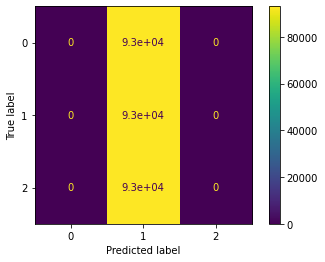

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_pred = [np.argmax(p) for p in model.predict(y_encoded)]
cm = confusion_matrix(y_true=[np.argmax(i) for i in y_encoded], y_pred=y_pred, labels=[0,1,2])
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2]).plot(include_values=True)
plt.savefig('bar.png')

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred = [np.argmax(p) for p in model.predict(y_encoded)]
y_pred = np.eye(NUM_CLASSES)[y_pred]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(NUM_CLASSES):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i], color='orange')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic class %s' % i)
    plt.legend(loc="lower right")
    plt.show()